In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
from clustering import clusterer

% matplotlib inline

In [2]:
# Create a Dataframe and drop extra column
df = pd.read_csv('../data/seattle_911_prepped_no_out.csv', low_memory=False)
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [3]:
df.head()

,Address,Type,Datetime,Latitude,Longitude,Report Location,Incident Number,dt_crop,date,time,...,day_num,neighborhood,zone1,zone2,zone3,zone4,zone5,zone6,zone7,seasonality
0,11747 Bartlett Av Ne,Medic Response,2010-06-29 08:00:00,47.713787,-122.283848,NaN,NaN,06/29/2010 08:00:00 AM,2010-06-29,08:00:00,...,0,Matthews Beach,0,1,0,0,0,0,0,1.824157
1,700 6th Av S,Aid Response,2010-06-29 07:49:00,47.596676,-122.326370,NaN,NaN,06/29/2010 07:49:00 AM,2010-06-29,07:49:00,...,0,International District,0,0,0,0,1,0,0,1.824157
2,7751 26th Av Nw,Aid Response,2010-06-29 07:49:00,47.685264,-122.389777,NaN,NaN,06/29/2010 07:49:00 AM,2010-06-29,07:49:00,...,0,Loyal Heights,1,0,0,0,0,0,0,1.824157
3,5241 33rd Av S,Aid Response,2010-06-29 07:50:00,47.554718,-122.290486,NaN,NaN,06/29/2010 07:50:00 AM,2010-06-29,07:50:00,...,0,Mid-Beacon Hill,0,0,0,0,0,0,1,1.824157
4,509 3rd Av,Auto Fire Alarm,2010-06-29 07:50:00,47.602114,-122.330809,NaN,NaN,06/29/2010 07:50:00 AM,2010-06-29,07:50:00,...,0,Pioneer Square,0,0,0,0,1,0,0,1.824157


In [4]:
# Remove extraneous columns and create a history lookup dataframe
df_hist = df.drop(labels=(['Address', 'Type', 'Report Location', 'Incident Number',
                           'dt_crop', 'neighborhood', 'date2', 'time2', 'Monday',
                           'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday',
                           'time', 'Datetime', 'date']), axis=1)
df_hist.head()

,Latitude,Longitude,mariners_home,seahawks_home,sounders_home,trav_holiday,dang_holiday,weekday,night,day_num,zone1,zone2,zone3,zone4,zone5,zone6,zone7,seasonality
0,47.713787,-122.283848,0,0,0,0,0,Tuesday,0,0,0,1,0,0,0,0,0,1.824157
1,47.596676,-122.326370,0,0,0,0,0,Tuesday,0,0,0,0,0,0,1,0,0,1.824157
2,47.685264,-122.389777,0,0,0,0,0,Tuesday,0,0,1,0,0,0,0,0,0,1.824157
3,47.554718,-122.290486,0,0,0,0,0,Tuesday,0,0,0,0,0,0,0,0,1,1.824157
4,47.602114,-122.330809,0,0,0,0,0,Tuesday,0,0,0,0,0,0,1,0,0,1.824157


In [5]:
df_hist.columns

Index([u'Latitude', u'Longitude', u'mariners_home', u'seahawks_home',
       u'sounders_home', u'trav_holiday', u'dang_holiday', u'weekday',
       u'night', u'day_num', u'zone1', u'zone2', u'zone3', u'zone4', u'zone5',
       u'zone6', u'zone7', u'seasonality'],
      dtype='object')

In [7]:
df_hist.to_csv('../data/hist_data_no_out.csv')

In [6]:
def hist_retriever(df, mariners, seahawks, sounders, date_, night, zone):
    """
    Input:
    df = Pandas DataFrame of hist_date_no_out.csv
    mariners, seahawks, sounders = 0 if no home game and 1 if homegame
    date = date of interest
    night = 0 if 6am to 6pm (day) and 1 if 6pm to 6am (night)
    zone = string such as 'zone1' indicating zone of interest
    Ouput: History DataFrame
    """

    # Busy travel times (2010-2020)
    trav_hol = ['2010-11-23', '2010-11-25', '2010-11-26', '2010-12-24',
                '2010-12-25', '2010-12-26',
                '2011-11-23', '2011-11-24', '2011-11-25', '2011-12-24',
                '2011-12-25', '2011-12-26',
                '2012-11-21', '2012-11-22', '2012-11-23', '2012-12-24',
                '2012-12-25', '2012-12-26',
                '2013-11-27', '2013-11-28', '2013-11-29', '2013-12-24',
                '2013-12-25', '2013-12-26',
                '2014-11-26', '2014-11-27', '2014-11-28', '2014-12-24',
                '2014-12-25', '2014-12-26',
                '2015-11-25', '2015-11-26', '2015-11-27', '2015-12-24',
                '2015-12-25', '2015-12-26',
                '2016-11-23', '2016-11-24', '2016-11-25', '2016-12-24',
                '2016-12-25', '2016-12-26',
                '2017-11-22', '2017-11-23', '2017-11-24', '2017-12-24',
                '2017-12-25', '2017-12-26',
                '2018-11-21', '2018-11-22', '2018-11-23', '2018-12-24',
                '2018-12-25', '2018-12-26',
                '2019-11-27', '2019-11-28', '2019-11-29', '2019-12-24',
                '2019-12-25', '2019-12-26',
                '2020-11-25', '2020-11-26', '2020-11-27', '2020-12-24',
                '2020-12-25', '2020-12-26' ]

    # Dangerous holidays are New Years day and July 4th (2010-2020)
    dang_hol = ['2010-01-01', '2010-07-04', '2011-01-01', '2011-07-04',
                '2012-01-01', '2012-07-04', '2013-01-01', '2013-07-04',
                '2014-01-01', '2014-07-04', '2015-01-01', '2015-07-04',
                '2016-01-01', '2016-07-04', '2017-01-01', '2017-07-04',
                '2018-01-01', '2018-07-04', '2019-01-01', '2019-07-04',
                '2020-01-01', '2020-07-04']

    # If major travel holiday, look up historical data on travel holidays
    if date_ in trav_hol:
        history = df[(df.trav_holiday == 1) &
                     (df.night == night) &
                     (df[zone] == 1)]

    # If 4th of July or New Years day, look up historical data on those days
    elif date_ in dang_hol:
        history = df[(df.dang_holiday == 1) &
                     (df.night == night) &
                     (df[zone] == 1)]

    # Grab historical data based on home games, weekday, and area of Seattle
    else:
        date_ = pd.to_datetime(date_)
        weekday = date_.weekday_name
        history = df[(df.mariners_home == mariners) &
                     (df.seahawks_home == seahawks) &
                     (df.sounders_home == sounders) &
                     (df.weekday == weekday) &
                     (df.night == night) &
                     (df[zone] == 1)]
        # If dataset is too small for meaningful clustering, generalize
        if len(history) < 200:
            history = df[(df.mariners_home == mariners) &
                         (df.seahawks_home == seahawks) &
                         (df.sounders_home == sounders) &
                         (df.night == night) &
                         (df[zone] == 1)]

    return history


In [15]:
history = hist_retriever(df=df_hist, mariners=0, seahawks=1, sounders=0, 
                         date_='2016-11-18', night=1, zone='zone7')

In [16]:
history.shape

(977, 18)

In [17]:
centroids, clusters = clusterer(history, k=8)

In [18]:
centroids

[(47.589109350993361, -122.32390430463579),
 (47.548848686746972, -122.31869257831326),
 (47.537019451063834, -122.27820901702134),
 (47.558191039999983, -122.28701380000001),
 (47.513071653543328, -122.26491800787394),
 (47.575503564885452, -122.2946872900763),
 (47.576218830000009, -122.32212503999999)]

In [19]:
centroid_df = pd.DataFrame(centroids)
centroid_df.columns = ['Latitude', 'Longitude']
centroid_df

,Latitude,Longitude
0,47.589109,-122.323904
1,47.548849,-122.318693
2,47.537019,-122.278209
3,47.558191,-122.287014
4,47.513072,-122.264918
5,47.575504,-122.294687
6,47.576219,-122.322125


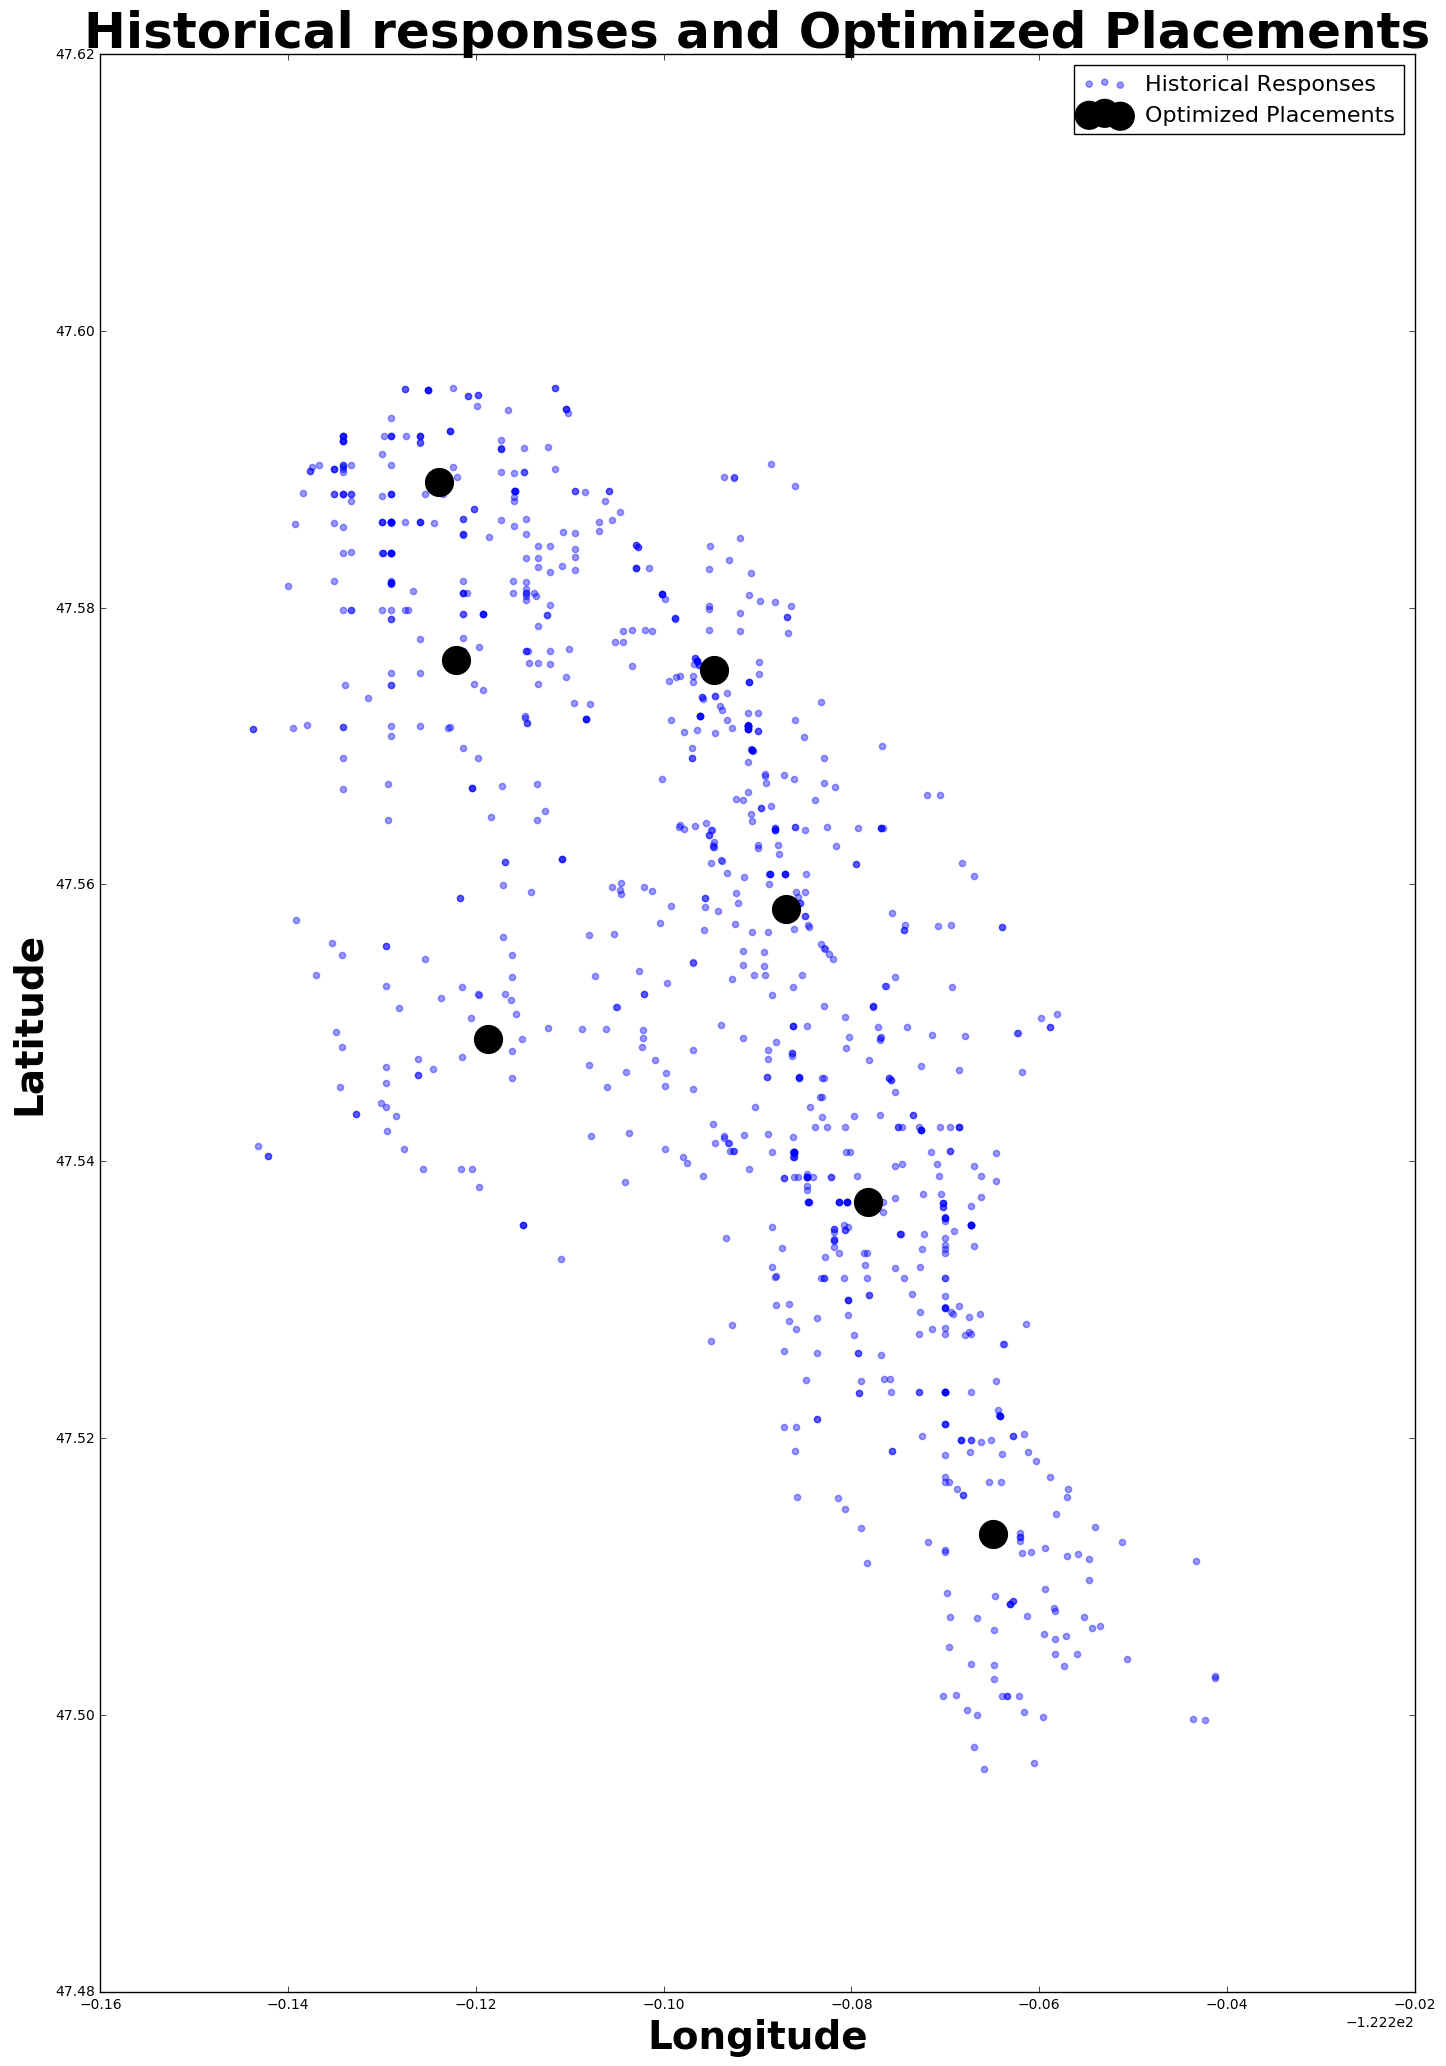

In [20]:
# Plot locations of police responses, actual SPD loc and optimal SPD loc
plt.figure(figsize=(16.96,25))
plt.scatter(history.Longitude, history.Latitude, s=20, alpha=0.4, color='b')
plt.scatter(centroid_df.Longitude, centroid_df.Latitude, s=400, color='k')
plt.xlabel('Longitude', fontsize=28, fontweight='bold')
plt.ylabel('Latitude', fontsize=28, fontweight='bold')
plt.title('Historical responses and Optimized Placements', fontsize=36, fontweight='bold')
plt.legend(['Historical Responses', 'Optimized Placements'], fontsize=16)